# Ultimate Challenge


In [1]:
#import the libraries first:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
#plot arrangements:
sns.set(rc={"figure.figsize": (18, 6), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes' , labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes' , titlesize=18)                                  # fontsize of the plot title

# Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
# Load json file into pandas dataframe
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Look at the dataframe stucture
logins.info()
logins.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


(93142, 1)

In [5]:
# Look at the dataframe statistics
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


# First Sight:

In this data; there is one column to show the date/time of login belonging different users from January to middle of April. In other words, besides the login_time there are no additional columns. As a result, I don't believe there are any issues with data quality here (no null values or outliers).

Before I resample the dataset to 15minute intervals, I will create an additional column to count the data. Then I will assign the index to the datetime series for resampling.

In [6]:
# First index on the timestamp column
logins.set_index('login_time', inplace=True)

# Add a numeric column for resampling to aggregate
logins['login'] = 1

logins.head()

,login
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [7]:
# Resample the data by aggregating login counts based on 15 minute time intervals
grouped_login = logins.resample('15T').sum()

# Look at the head of the resampled logins
grouped_login.head()

,login
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


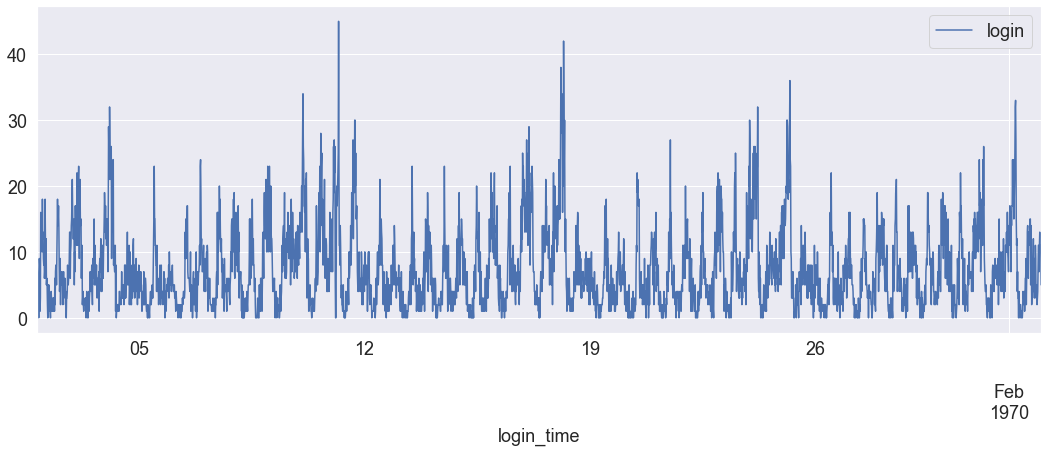

In [8]:
#focus to 1 month instead of 3.5 months:
logins.resample('15T').sum()['1970-01-01':'1970-02-01'].plot()
plt.show()

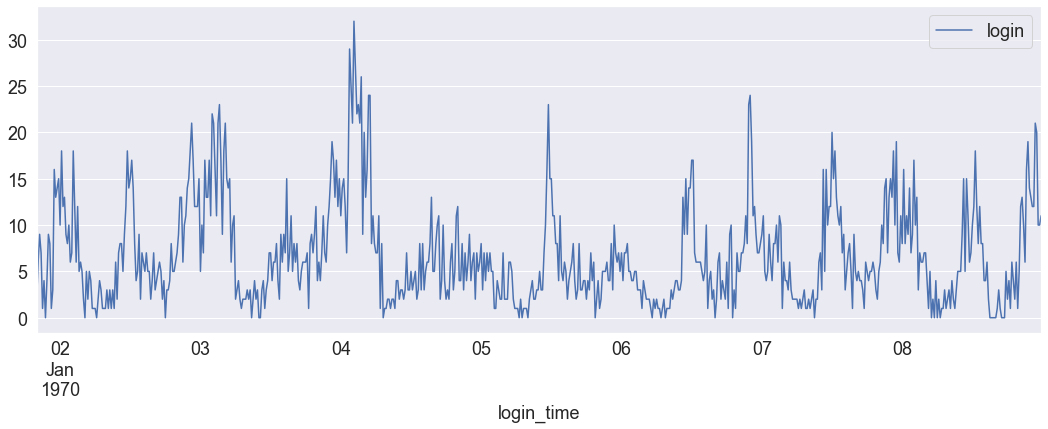

In [9]:
#zoom 1 week to catch the rythm better:
logins.resample('15T').sum()['1970-01-01':'1970-01-08'].plot()
plt.show()

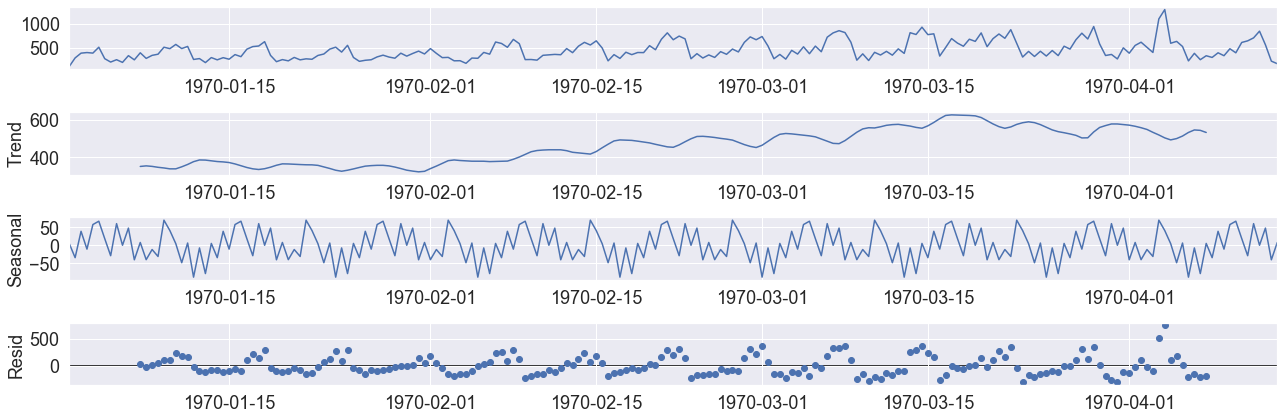

In [10]:
#see this obvious 12h scale/harmony on the seasonal basis:
decomposition = sm.tsa.seasonal_decompose(logins.resample('12H').sum())
decomposition.plot()
plt.show()

In [11]:
#There is a consistent pattern in 12H basis.
#Let's see it through the week for all 3.5 months period by regrouped dataset per 15m.
#First, iterate this regrouped dataset over daily basis for 3.5 months period
resample_daily_list = []
for group in grouped_login.groupby(pd.Grouper(freq='D')):
    resample_daily_list.append(group[1])

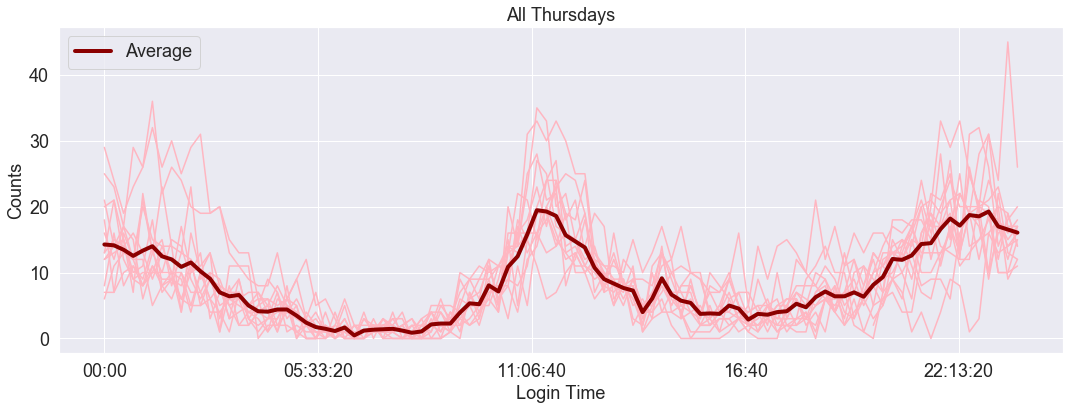

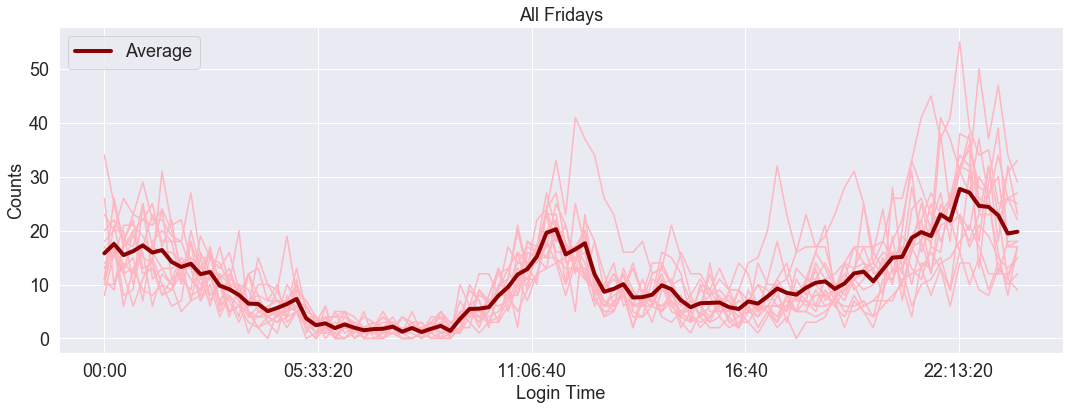

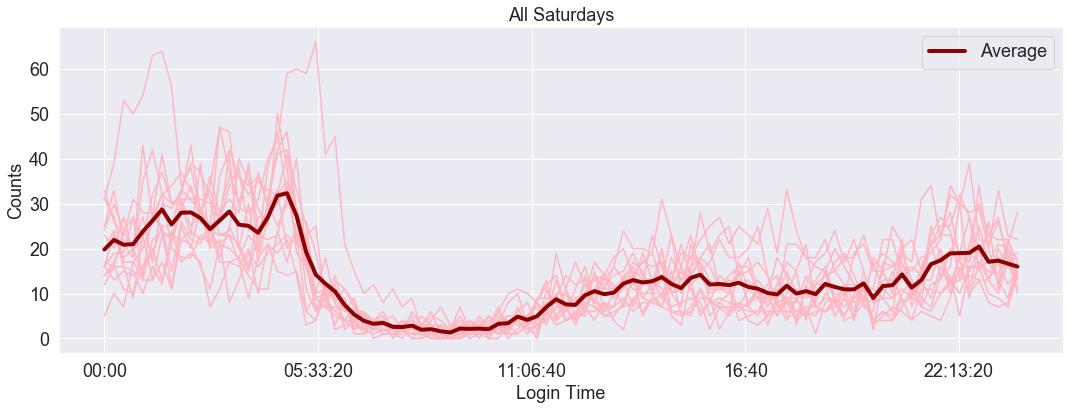

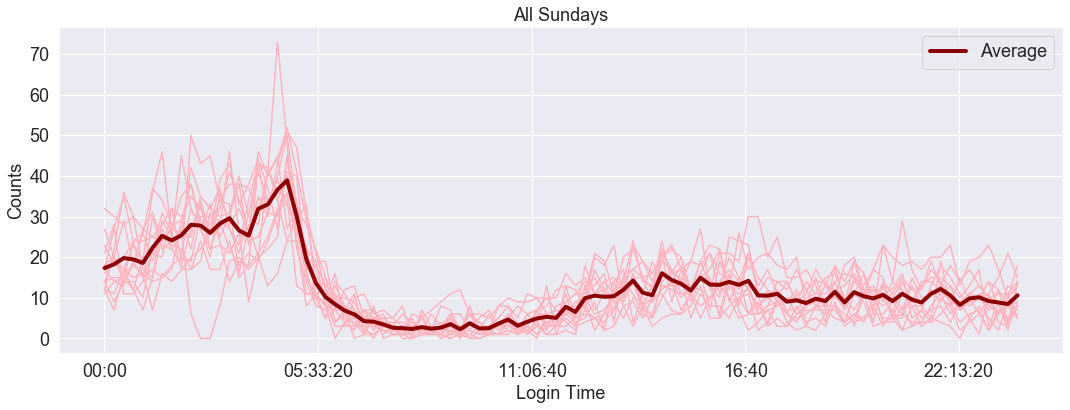

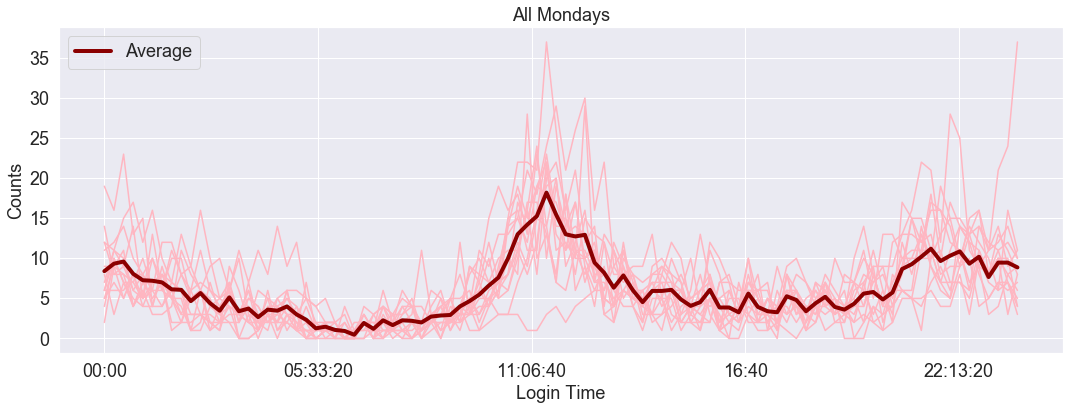

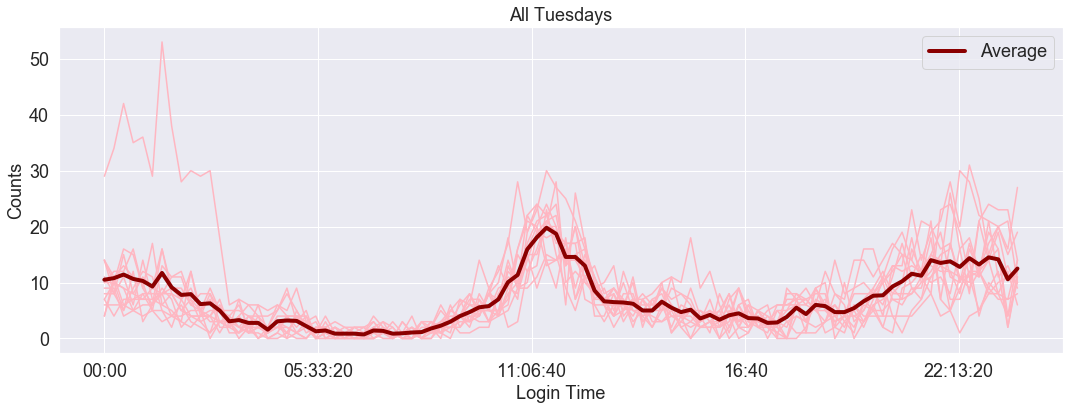

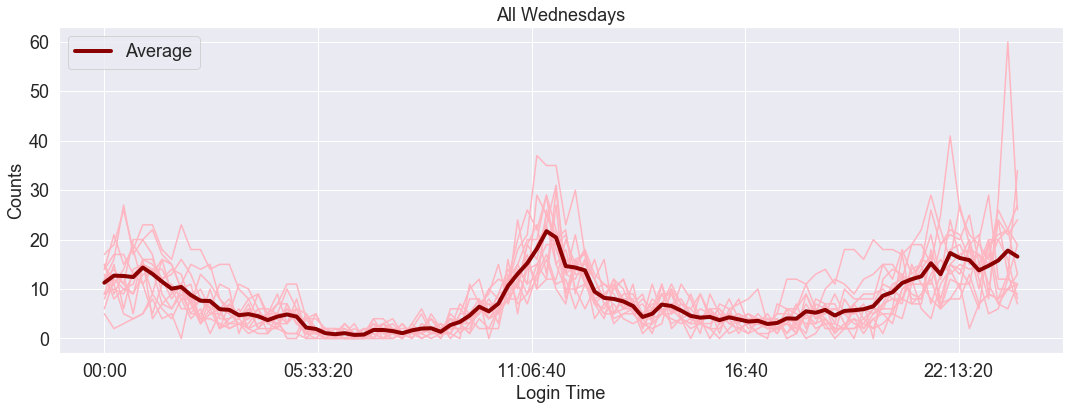

In [12]:
#The days to loop over
day_list = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']

#Create a dict for holding the running counts 
avg_index = defaultdict(int)
for i, t in enumerate(pd.timedelta_range(0, periods=24*4, freq='15T')):
    avg_index[i] = datetime.datetime.strptime(str(t).replace('0 days ',''), '%H:%M:%S').time()

#Loop over the 7 days    
for i in range(len(day_list)):
    
    #Create the dataframe to hold the running counts
    avg_df = pd.DataFrame(avg_index.items(), columns=['login', 'login_time'])
    avg_df.login = 0
    avg_df.set_index('login_time', inplace=True)
    
    #Run through grouped day list
    day_range = range(i, len(resample_daily_list), len(day_list))
    for j in day_range:

        #Extract the dataframe
        df = resample_daily_list[j]
        df = df.set_index(df.index.to_series().dt.time)
        
        #Add the values of this dataframe to running count
        avg_df = avg_df.add(df, fill_value=0)              
        
        #Plot the time series
        if j < len(day_list):
            ax = df.plot(legend=False, color='lightpink')
        else:
            df.plot(ax=ax, legend=False, color='lightpink')
            
    #Create the average and plot    
    avg_df['Average'] = avg_df.login/float(len(day_range))
    avg_df.drop('login', axis=1, inplace=True)
    avg_df.plot(ax=ax, legend=True, color='darkred', lw=4.)
    
    #Plot the full graph
    ax.set_title('All ' + day_list[i] + 's')
    ax.set_xlabel('Login Time')
    ax.set_ylabel('Counts')
    plt.show()

## Conclusion accoording to iterated dataset through the week for all 3.5 months period by regrouped dataset per 15m:

While there is an obvious pick at 11am in weekdays, there is a different pattern for saturday and sunday which may explain the late night logins. 4am is the most popular time for weekends login.

- Monday through Friday have similar trends. There is a surge of activity around lunch time (12PM) and late evening (10PM). Activity is also at its lowest at 7AM.

- For Saturday and Sunday, they have their own trends with peak activity at 5AM, lowest activity around 9AM, and leveled throughout.

- Monday overall has lower activity whereas Friday - Sunday have highest activity (see y-axis scale).

- With these plots, it does seem that weekdays/workdays have significant different activties compared to the weekends.

## Conclusion:

- The login count is showing progressive growth.

- There are weekly trends in login activity, particular with the highs from Friday to Sunday and lows from Monday to Thursday.

- Within the weekday, there is increased activity around noon (12PM) and late evening (10PM). The activity carries over to very early morning the next day (2AM). Lowest activity occurs at 7AM.

- On the weekends, there are large amounts of activity starting from the start of the day until 5AM where it peaks and starts to decline. It reaches its lowest at 9AM and levels to around the average for the remainder of the day.

## To final this task, let's create a dateframe to see the am-pm and the days of the week seperately:

In [13]:
logins = pd.read_json('logins.json')
logins = logins.resample("15min", on="login_time").count()
logins.index.name = "time"
logins.reset_index(inplace=True)
logins.rename({'login_time':"login"}, axis=1, inplace=True)
logins.head()

,time,login
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [14]:
#extracting hours and days
logins["hour"] = logins["time"].dt.hour
logins["day"] = logins["time"].dt.day_name()

#giving AM/PM labels
day_or_night = lambda row: "AM" if row in range(0,12) else "PM"
logins["AM-PM"] = logins["hour"].apply(day_or_night)

#show
display(logins.head())

,time,login,hour,day,AM-PM
0,1970-01-01 20:00:00,2,20,Thursday,PM
1,1970-01-01 20:15:00,6,20,Thursday,PM
2,1970-01-01 20:30:00,9,20,Thursday,PM
3,1970-01-01 20:45:00,7,20,Thursday,PM
4,1970-01-01 21:00:00,1,21,Thursday,PM


In [15]:

#getting total logins per day of week
df_day = logins.groupby("day").sum()[["login"]]

#getting average daily logins per day of week
df_day["daily_avg"] = logins.groupby("day").mean()[["login"]]

#show
display(df_day)

,login,daily_avg
day,,
Friday,15208,10.561111
Monday,8823,6.213380
Saturday,19377,13.456250
Sunday,18167,12.615972
Thursday,11960,8.794118
Tuesday,9268,6.895833
Wednesday,10339,7.692708


In [16]:

#aggregating by sum
df_total = logins.groupby(["day", "AM-PM"]).sum()[["login"]]

#aggregating by mean
df_total["total_avg"] = logins.groupby(["day", "AM-PM"]).mean()[["login"]]

#show
display(df_total)

login  total_avg
day       AM-PM                  
Friday    AM      5924   8.227778
          PM      9284  12.894444
Monday    AM      3905   5.423611
          PM      4918   7.025714
Saturday  AM     10217  14.190278
          PM      9160  12.722222
Sunday    AM     10351  14.376389
          PM      7816  10.855556
Thursday  AM      5153   7.668155
          PM      6807   9.893895
Tuesday   AM      3961   5.894345
          PM      5307   7.897321
Wednesday AM      4570   6.800595
          PM      5769   8.584821

# Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

## Question 1:
What would you choose as the key measure of success of this experiment in  encouraging driver partners to serve both cities, and why would you choose this metric?

### Answer 1:

We can compare pre-toll vs. post-toll ridership using A/B testing. If drivers being exclusive to one city really affects business then it must be because of lack of supply, extending the waiting times for riders and driving the cost higher as well. We can then use these characteristics as the metric as basis for comparison:

Compare daily average wait times (time driver arrives vs. time rider sends request) in either city prior to the change and after
Compare daily average price during rush hour (dollar per mile cost that includes surge pricing due to demand) prior to the change and after
Compare daily rate of denied service (i.e. how many times users are turned down for being too far) prior to the change and after
These parameters can simply be extracted from the internal database before and after the implementation of the reimbursement program. The hypothesis testing will be done on each of the three metrics above. Using the first item, average wait times, as an example, the null hypothesis would be that the difference between the two means will be zero (or that they are equal).

Now, since the statistic is daily, we can use a timeframe (say, 20 days) in which each day is a trial of the experiment -- so it will be 20 days during without reimbursement period, compared with 20 days during with reimbursement period. This will ensure randomness as long as this sample is not more than 10% of the actual length of the period (so the program must go on for at least 200 days).

From there, we can simulate the assumption of our null hypothesis by shuffling the labels of our means (half of the sample is randomly assigned as have occurred with reimbursement). Let's say that the target for the average wait time is a 10-second improvement -- our observed test statistic. The p-value is then the probability that a user waited 10-seconds less than when there was no reimbursement in these randomized circumstances. If this event happens less frequently than 5% of the time, then we know it's unlikely to occur. And so encountering a difference of 10-seconds waiting time is considered to be statistically significant.

If we disprove the null hypothesis (the status quo) for all the three metrics, then we have proven that the reimbursement program works. The next step then is to contrast the cost of the total reimbursements against the gains in revenue. And as contingency, also work out the impact of reverting back to the unsubsidized approach.

### Answer 2:
We can assume data is always being collected. Thus we can measure our KPI before our experiment actually begins. It is important to know these numbers before the experiment starts, since that is what we will be comparing to. In some sense, this can be thought of as an A/B test, so we need to know the data very well before the change. Further, we also need to make sure we don't bias or pollute the data by announcing the experiment or change too prematurely. We don't want upcoming news to change behavior making it difficult for us to determine the results of the experiment.

Then we can announce the change and begin the toll reimbursement program. We would then start monitoring the new data. We would have to run the experiment for at least some amount of time. This could be a week or a month. It depends entirely on the scale of the data involved. We would use a statistical power test to estimate the data required to be able to discern any statistical significance. Then we could run a two-tailed $z$-test comparing sample proportions (since that is what the ratio is). This would give us a $z$-score and associated $p$-value. A low $p$-value (say at $\alpha$=0.01) would potentially indicate a significant change in our KPI (good or bad). We could further calculate the confidence intervals for this to be able to strongly claim a statistical change in the KPI, if it exists.

Assuming our KPI does change, and in a positive direction, then we still have to be mindful of the results. We could see positive change, where more drivers are now in the city other than their primary. However, we have to estimate the amount of revenue that exact change has brought and compare it to the cost of the program (remember Ultimate is paying the tolls!). A positive KPI change coupled with negative revenue is perhaps not the ideal. We also mentioned that while the program can result in a statistical change in the KPI, it could lead to worse results. So the analysts need to be aware of this fact as well. Further, this ratio metric is time agnostic, ignoring weekdays, weekends, day or night. A further iteration of this analysis would also include this (by perhaps binning in time) 


Success Metrics

The best metric for success would be the percentage of drivers who cross the bridge from the city with less demand to the city with greater demand when there is a demand imbalance in a given period of time. To perform the experiment properly, we would want to know with high confidence what percentage of drivers cross the bridge when Ultimate doesn’t pay the toll so we can see how much this increases when Ultimate pays the toll. We would want this increase to be as large as possible.

If we add a little more complexity to the question, and a lot more verbosity, in order to have a more accurate answer from the revenue maximization point of view, the metric we might want to maximize would be ‘the percentage of drivers who cross the bridge such that Ultimate believes that the extra revenue gained per trip by crossing more than offsets the cost of crossing.

2. Describe    a    practical     experiment     you    would    design     to     compare     the    effectiveness    of     the  proposed     change     in     relation     to     the     key    measure    of     success.    Please    provide    details     on:  

### a. How     you    will     implement     the    experiment? 

- Before implementing the proposed change (paying drivers’ toll fees) we would want to get a really strong estimate of what percentage of drivers already cross the bridge and pay the toll in order to take advantage of the higher demand in the other city.

- We would then want to see what that number changes to when we pay the toll fees.

- In terms of practical implementation, this should not be difficult to implement assuming Ultimate has an app that tracks drivers locations as well as the current average demand in each city (as given by price/unit distance).

### b. What     statistical     test(s)     you    will     conduct     to     verify     the     significance    of     the  observation 

We would use a hypothesis test comparing population proportions where the proportion in question is the percentage of drivers who cross from the city with less demand to the city with greater demand in a given frame of time. Our null hypothesis would be that the proportion is the same irrespective of our proposed change.

### c. how     you    would     interpret     the     results    and    provide     recommendations     to     the     city  operations     team    along    with    any     caveats. 

If we saw that the change in proportion (or percentage) of drivers who cross the bridge from the city with greater demand to the city with less demand in a given period was large, than we would know that paying the drivers’ toll fees was an effective intervention, at least in terms of meeting demand quicker. If we saw that this percentage change was small, then we would know that the proposed change was not effective, and we would need to provide additional incentives to drivers to cross the bridge.

My recommendations to the operations team would depend a lot on some of the considerations already mentioned above. That is, does demand remain strong enough in the city to which drivers are going and do drivers perform enough trips in the ‘new’ city to justify the cost of having Ultimate pay the toll? Ideally there should be some analysis performed on this question before the change is implemented to know whether the change should be made in the first place. But some questions can only be answered with real data, so from my perspective, as a consultant tasked with maximizing Ultimate’s revenue, I would want to know if the net effect to revenue from paying the tolls before recommending to city managers whether to keep the change or not.





# Part - 3: Predictive Modeling

- Ultimate     is     interested     in     predicting     rider     retention.    To    help    explore     this    question,    we    have  provided     a     sample    dataset     of     a     cohort    of    users    who     signed    up     for    an    Ultimate    account     in  January    2014.    The     data    was    pulled     several    months     later;    we     consider    a    user     retained     if     they  were     “active”     (i.e.     took    a     trip)     in     the     preceding    30    days.   

- We     would     like     you     to    use     this    data     set     to    help    understand    what     factors    are     the    best    predictors  for     retention,    and    offer     suggestions     to     operationalize     those     insights     to    help    Ultimate.    The    data     is     in     the    attached     file     ultimate_data_challenge.json.    

- See    below     for    a    detailed  description     of     the    dataset.     Please     include    any     code     you    wrote     for     the    analysis    and    delete     the  dataset    when     you    have     finished     with     the     challenge.   

- 1. Perform    any     cleaning,     exploratory    analysis,    and/or     visualizations     to    use     the    provided  data     for     this    analysis     (a     few     sentences/plots    describing     your    approach    will     suffice).    What  fraction     of     the    observed     users    were     retained? 

- 2. Build    a    predictive     model     to     help    Ultimate    determine    whether    or    not    a    user    will    be    active  in     their    6th    month     on     the     system.    Discuss    why     you     chose     your    approach,    what  alternatives     you     considered,     and    any     concerns     you    have.    How     valid     is     your    model?  Include    any     key     indicators    of     model    performance. 

- 3. Briefly    discuss    how     Ultimate     might     leverage     the     insights    gained     from     the    model     to  improve     its     long  term     rider     retention     (again,    a     few     sentences    will     suffice).


# Data Description

● city:       city     this    user     signed     up     in 

● phone:      primary    device     for     this    user 

● signup_date:      date     of     account     registration;     in     the     form     ‘YYYY MM DD’ 

● last_trip_date:       the     last     time     this    user     completed    a     trip;     in     the     form     ‘YYYY MM DD’ 

● avg_dist:       the    average     distance     in    miles    per     trip     taken     in     the     first    30    days    after     signup 

● avg_rating_by_driver:       the     rider’s    average     rating    over    all    of     their     trips 

● avg_rating_of_driver:       the     rider’s    average     rating    of     their    drivers    over    all    of     their     trips 

● surge_pct:       the    percent     of     trips     taken    with     surge    multiplier    >    1 

● avg_surge:       The    average     surge    multiplier    over    all    of     this    user’s     trips 

● trips_in_first_30_days:       the     number    of     trips     this    user     took     in     the     first    30    days    after  signing    up  

● ultimate_black_user:       TRUE     if     the    user     took    an    Ultimate    Black     in     their     first    30    days;  FALSE    otherwise 

● weekday_pct:       the     percent     of     the    user’s     trips    occurring    during    a    weekday

# Load and Inspect the data

In [17]:
# Read json data into dataframe
with open('ultimate_data_challenge.json') as f:
    ultimate = json.load(f)

#Convert to dataframe
ultimate = pd.DataFrame(ultimate)

#Convert the time series to datetimes 
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])

ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


# Exploratory Data Analysis

In [18]:
# The data structure info
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [19]:
# Data statistics
ultimate.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [20]:
# Comparing two datatime columns' statistics
ultimate[['signup_date', 'last_trip_date']].describe()

,signup_date,last_trip_date
count,50000,50000
unique,31,182
top,2014-01-18 00:00:00,2014-06-29 00:00:00
freq,2948,2036
first,2014-01-01 00:00:00,2014-01-01 00:00:00
last,2014-01-31 00:00:00,2014-07-01 00:00:00


In [21]:
# Missing values
ultimate.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [22]:
# Categorical column's unique values ('city')
ultimate['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [23]:
# Categorical column's unique values ('phone')
ultimate['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

### We have 50000 observations and 12 columns in the dataset. The dataset has missing values in "avg_rating_by_driver", " avg_rating_of_driver", and "phone" whose data types are float64, float64 and object respectively. The data ranges about 6 months from January 1 to July 1, of 2014. There are two categorical variables, city and phone. Each of these only has three and two categories, respectively.

In [24]:
active_dict = {x:False for x in range(0, len(ultimate))}

#Loop over rows
for i in range(len(ultimate)):
    
    #Set the start date of this row
    start = ultimate['signup_date'][i]
    
    #Set the end date for this row: 6 months later
    end = start + pd.Timedelta('181D')
    
    #Set the time window, a month before end date
    previous = end - pd.Timedelta('30D')
    
    #Was the last trip within the last month?
    if previous <= ultimate['last_trip_date'][i] <= end:
        active_dict[i] = True

#What is the percentage of active users?
num_active = sum(active_dict.values())
per_active = num_active/len(active_dict)
print(num_active, per_active)

12198 0.24396


### 24% users are active in the system.

## Let's create a column 'is_active' based on our finding. This column will be our target variable for the modelling.

In [25]:
ultimate['is_active'] = (ultimate['last_trip_date'] >= '2014-06-01')
ultimate.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


### There isn't really much more cleaning we need to do right now. If we notice something is off in the data while doing EDA or modelling, we can come back and clean it, but based on our summaries of the data so far, it looks OK.

## Let's do some basic EDA showing relationships between numerical features and target target variable

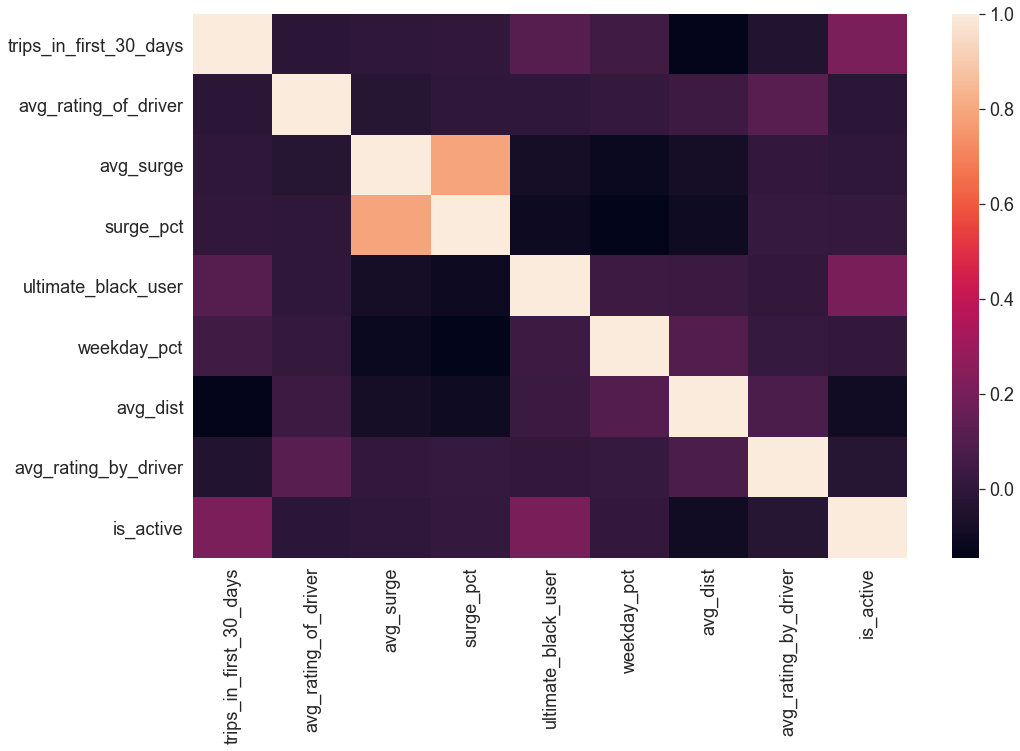

In [26]:
plt.figure(figsize=(16, 10))
ax = plt.subplot(111)
corr = ultimate.corr()
ax = sns.heatmap(corr)
plt.show()

In [27]:
# Target variable and numerical features correlation
corr['is_active'].sort_values(ascending = False)

is_active                 1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: is_active, dtype: float64

We see that whether a user was active or not in the system is somewhat correlated with the number of trips in the user's first 30 days and whether they are an Ultimate Black user or not. There isn't much correlation or anti-correlation with anything else.

We haven't yet seen though what the relationship is between is_active and our non-numeric columns: city, phone, and the two date columns. Let's try doing that here.

In [28]:

def graph_df(x, y = 'bar', z = 0):
    """
    This function creates graph for each feature in the dataset
    """
    
    feature = ultimate.groupby(x).agg({'is_active':['size', 'sum', 'mean']})
    feature.columns = [' '.join(col).strip() for col in feature.columns.values]
    feature = feature.reset_index()
    feature['is_active mean'] = feature['is_active mean']*100
    feature.columns = [x, 'Total Users', 'Active Number', 
                       '% of Active in the Relevant Group'] 
    
    fig0, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    feature.set_index(feature[x], drop=True, inplace=True)
    feature['Total Users'].plot(kind = y, stacked = True, ax = ax1, 
                                   colormap = 'winter', rot = z)
    feature['% of Active in the Relevant Group'].plot(use_index = False, 
                                                         kind = 'line', ax = ax2, colormap='Spectral')
    plt.title('Active status compared to' + " " + x  + " " + "Groups")
    ax1.set_xlabel(x)
    ax1.yaxis.label.set_color('blue')
    ax1.set_ylabel("Total Users ")
    ax2.set_ylabel("Active Percentage in the Relevant Group")
    ax2.yaxis.label.set_color('red')
    plt.tight_layout()
    plt.show()

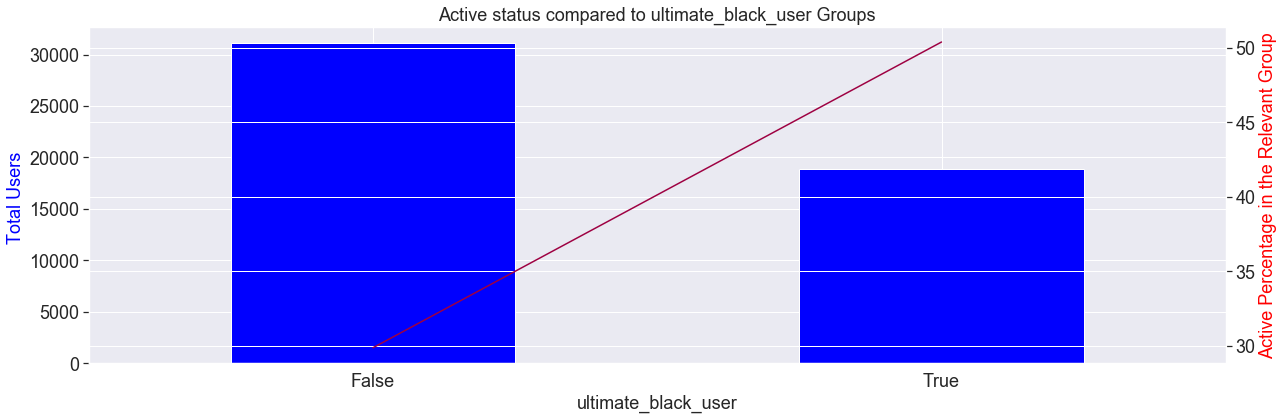

In [29]:
# Plot Target variable and Ultimate Black User Graph
graph_df('ultimate_black_user')


### Ultimate Black Users are much more likely to be active in the system as compared to the rest of the users.

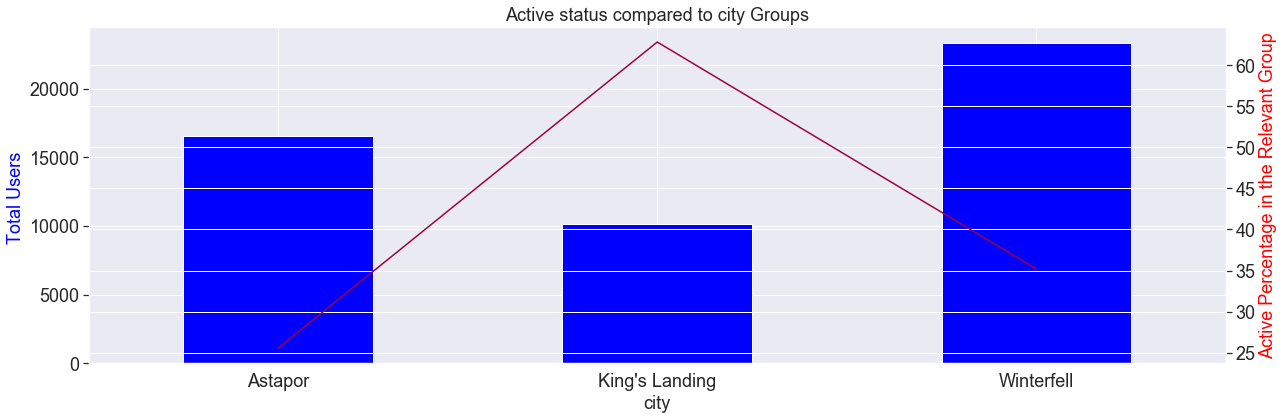

In [30]:
# Plot Target variable and city groups
graph_df('city')

- King's Landing seems to be especially successful in retaining users whereas Astapor is the least successful.

- Both columns have string values. The best way to handle these 2 columns is to one-hot-encode them. Before we can continue though, we must fill in the null values for the phone column so that we can one-hot-encode them properly in scikit-learn when we need to.

In [31]:
# Fill NAN values in phone column with 'Other'
ultimate['phone'].fillna('Other', inplace=True)
ultimate['phone'].value_counts()

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64

In [32]:
# Creating dummy variables for 'city' and 'phone' 
cities_ohe = pd.get_dummies(ultimate['city'])
phones_ohe = pd.get_dummies(ultimate['phone'])

In [33]:
# Join the dummy variables with the dataframe
ultimate = ultimate.join(cities_ohe).join(phones_ohe)

In [34]:
# Drop redundant features
ultimate.drop(['city', 'phone'], axis=1, inplace=True)

In [35]:
# Move the target variable ('is_active') to the end of the dataset.
col_at_end = ['is_active']
ultimate = ultimate[[col for col in ultimate if col not in col_at_end]
                    + [col for col in col_at_end if col in ultimate]]

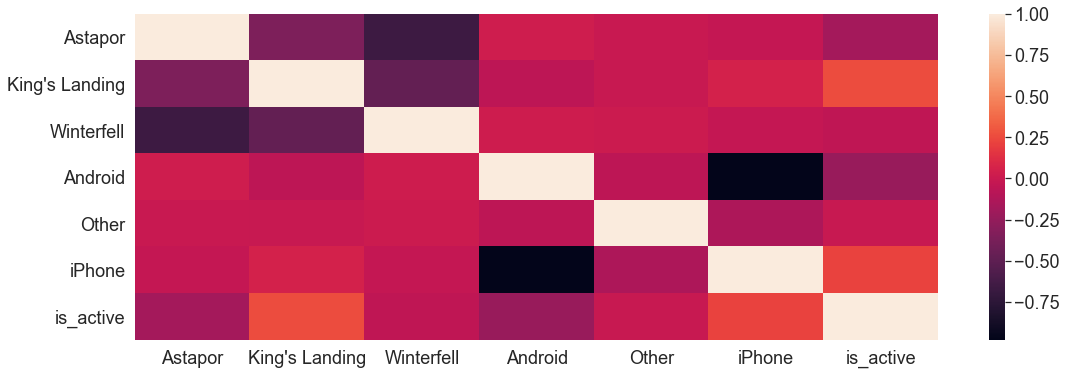

In [36]:
# Let's look for correlation between categorical features
categoricals = ultimate.iloc[:,-7:]
fig = plt.figure()
ax = plt.subplot(111)
corr = categoricals.corr()
ax = sns.heatmap(corr)
plt.show()

In [37]:

corr['is_active'].sort_values(ascending=False)

is_active         1.000000
King's Landing    0.262284
iPhone            0.225244
Other            -0.007419
Winterfell       -0.046611
Astapor          -0.174655
Android          -0.225464
Name: is_active, dtype: float64

- We see that being from King's Landing and using an iPhone are associated with being retained. Being from Astapor or Winterfell or using an Android are negatively associated with retention.

- With regard to the 2 date columns, if we want to see their correlation with retention, we need to first encode them numerically. We will check how much each is correlated with retention. Obviously, we expect last_trip_date to have a high correlation with retention because the retention column was created from last_trip_date. In the actual model, we will remove last_trip_date in order to prevent it from giving us artificially good performance.

In [38]:
ultimate['signup_date'].describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

In [39]:

ultimate['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [40]:

ultimate['signup_date'] = ultimate['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100

In [41]:
ultimate['signup_date'].corr(ultimate['is_active'])

-0.020210618434848227

- It looks like 'signup date' is not really correlated with retention. Let's see about 'last_trip_date'. This should be very correlated.

In [42]:
ref = min(ultimate['last_trip_date'])
ultimate['last_trip_date'] = (ultimate['last_trip_date'] - ref).dt.days + 1 
# We add 1 because takes the number of days since the first day, not since last year

In [43]:

ultimate['last_trip_date'].corr(ultimate['is_active'])

0.7808374961937242

- As it is expected, the correlation between 'last trip date' and target variable.

- Let's convert the ultimate_black_user column to int so it shows up with the describe method.

In [44]:
ultimate['ultimate_black_user'] = ultimate['ultimate_black_user']*1

In [45]:
ultimate.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,Other,iPhone
count,50000.000000,50000.00000,41878.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,49799.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,16.54468,4.601559,1.074764,109.334780,8.849536,0.37708,60.926084,5.796827,4.778158,0.330680,0.202600,0.466720,0.300440,0.007920,0.691640
std,3.792684,8.75422,0.617338,0.222336,61.718985,19.958811,0.48466,37.081503,5.707357,0.446652,0.470463,0.401941,0.498896,0.458454,0.088642,0.461821
min,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.00000,4.300000,1.000000,45.000000,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,17.00000,4.900000,1.000000,128.000000,0.000000,0.00000,66.700000,3.880000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,24.00000,5.000000,1.050000,169.000000,8.600000,1.00000,100.000000,6.940000,5.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,125.000000,31.00000,5.000000,8.000000,182.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


At this point, we have looked at the relationship between every feature and our created target column 'was_retained'. To handle the 'city' and 'phone' categorical columns we needed to one-hot-encode the features first, and to handle the date columns, we simply converted those columns to the number of days into 2014.

Also, all of our features are numeric now, so we are ready for modelling.

# Modelling

### Let's setup a machine learning model to determine which users will be active 6 months after initially signing up.

Let's create the whole model using sklearn's Pipeline object. We will repull the data to do this.

In [46]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
ultimate = pd.DataFrame(data)

ultimate['is_active'] = (ultimate.last_trip_date >= '2014-06-01')*1
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])
ultimate['signup_date'] = ultimate['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
ultimate['last_trip_date'] = (ultimate['last_trip_date'] - min(ultimate['last_trip_date'])).dt.days + 1

## Step - 1: Preprocessing Data

We create the preprocessing pipelines for both numeric and categorical data.

In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve
import time

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint

In [48]:
np.random.seed(0)

ultimate['phone'].fillna('Other', inplace=True)
categorical_features = ['city', 'phone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())
]
)

numeric_features = [column for column in ultimate.columns.tolist() if column not in categorical_features and
                    column not in ['last_trip_date', 'is_active']]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
]
)

## Step - 2: Split Data into Training and Test Sets

In [49]:

X = ultimate.drop(['is_active', 'last_trip_date'], axis=1)
y = ultimate['is_active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

- Before we proceed further, we prepare a dataframe the will store the different scoring metrics that we will score each model with:

In [50]:

metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC', 'Time to Train'], 
                       columns=['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Naive Bayes'])

metrics

,Dummy Model,Logistic Regression,K Nearest Neighbors,Support Vector Machine,Decision Tree,Random Forest,Naive Bayes
accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AUC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time to Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step - 3: Instantiate the model

In [51]:
classifier_dm = DummyClassifier(strategy="most_frequent", random_state=0)
classifier_lr = LogisticRegression(solver='liblinear', random_state=0)
classifier_knn = KNeighborsClassifier()
classifier_svm = SVC(random_state=0)
classifier_dt = DecisionTreeClassifier(random_state=0)
classifier_rf = RandomForestClassifier(random_state=0)
classifier_nb = GaussianNB()

classifiers = [classifier_dm, classifier_lr, classifier_knn, classifier_svm, classifier_dt, classifier_rf, classifier_nb]

## Step - 4: Specify the Hyperparameter Space

In [52]:
param_grid_dm = None
param_grid_lr = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': np.logspace(-5, 8, 15),
    'classifier__penalty': ['l1', 'l2']
}
param_grid_knn = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_neighbors': np.arange(1,20)
}
param_grid_svm = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01]
}
param_grid_dt = {
                'preprocessor__num__imputer__strategy': ['mean', 'median'],
                'classifier__max_depth': [3, 10, 20, None],
                'classifier__max_features': randint(1, 9),
                'classifier__min_samples_leaf': randint(1, 9),
                'classifier__min_samples_split': randint(2, 9),
                'classifier__criterion': ["gini", "entropy"]
}
param_grid_rf = {
                 'preprocessor__num__imputer__strategy': ['mean', 'median'], 
                 'classifier__n_estimators': [50, 100],
                 'classifier__criterion': ["gini", "entropy"],
                 'classifier__max_depth': [3, 10, 20, None],
                 'classifier__min_samples_leaf': randint(1, 9),
                 'classifier__min_samples_split': randint(2, 9),
                 'classifier__max_features': randint(1, 9)
}
param_grid_nb = None

param_grids = [param_grid_dm, param_grid_lr, param_grid_knn, param_grid_svm, param_grid_dt, param_grid_rf, param_grid_nb]

model_names = ['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Naive Bayes']
cv_names = ['dm_cv', 'lr_cv', 'knn_cv', 'svm_cv', 'dt_cv', 'rf_cv', 'nb_cv']
cvs = [None, 5, 5, 5, 5, 5, 5]

## Step - 5: Train and score the model

In [53]:
def Conf_Matrix(CM, labels=['Not Retained', 'Retained']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

def train_and_score_model(model_name, estimator, param_grid=None, cv=5, iid=False):
    
    # Instantiate the CV Object
    
    if model_name in ['Dummy Model', 'Naive Bayes']:
        cv = estimator
    elif model_name == 'Logistic Regression':
        cv = GridSearchCV(estimator, param_grid, cv=cv, iid=False)
    else: 
        cv = RandomizedSearchCV(estimator, param_grid, cv=cv, iid=False, random_state=None)

    # Fit on Training
    t0 = time.time()
    cv.fit(X_train, y_train)
    ttt = time.time() - t0 # ttt stands for "time to train"
    print("It takes %.3f seconds for %s fitting" % (ttt, model_name))
    metrics.loc['Time to Train', model_name] = ttt

    # Predict on Test

    y_pred = cv.predict(X_test)

    # Scoring

    print("Accuracy with " + model_name + "on the testing set is: %.3f" % cv.score(X_test, y_test))

    metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
        
    if model_name != 'Support Vector Machine':
        y_pred_prob = cv.predict_proba(X_test)[:,1]
        metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred_prob)

    print(Conf_Matrix(confusion_matrix(y_test, y_pred)))
    print(classification_report(y_test, y_pred))

    if model_name != 'Support Vector Machine':
        # ROC Curve
        fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr, tpr, label=model_name)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('%s ROC Curve' % model_name)
        plt.show()

    return cv

## Append classifier to preprocessing pipeline. Now we have a full prediction pipeline.

It takes 0.122 seconds for Dummy Model fitting
Accuracy with Dummy Modelon the testing set is: 0.624
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          9359         0   9359
Retained              5641         0   5641
Total                15000         0  15000
              precision    recall  f1-score   support

           0       0.62      1.00      0.77      9359
           1       0.00      0.00      0.00      5641

    accuracy                           0.62     15000
   macro avg       0.31      0.50      0.38     15000
weighted avg       0.39      0.62      0.48     15000



C:\Users\guzel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guzel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


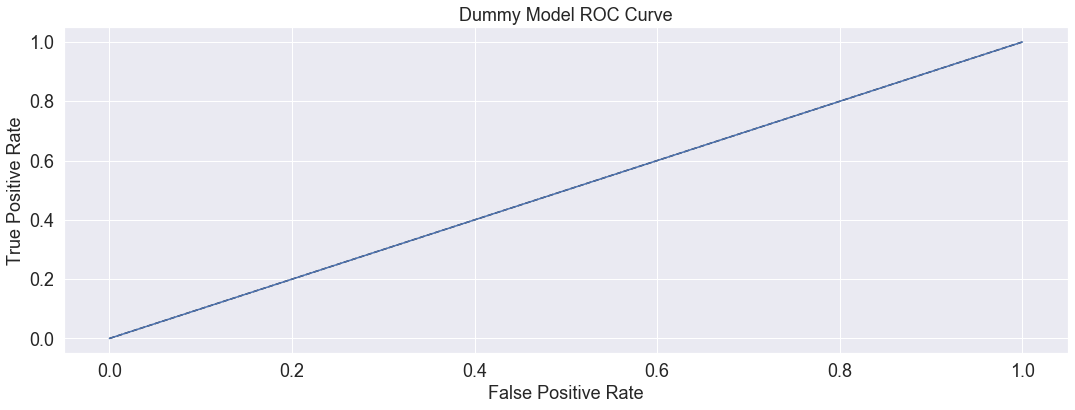

C:\Users\guzel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


It takes 48.210 seconds for Logistic Regression fitting
Accuracy with Logistic Regressionon the testing set is: 0.716
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7984      1375   9359
Retained              2880      2761   5641
Total                10864      4136  15000
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      9359
           1       0.67      0.49      0.56      5641

    accuracy                           0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



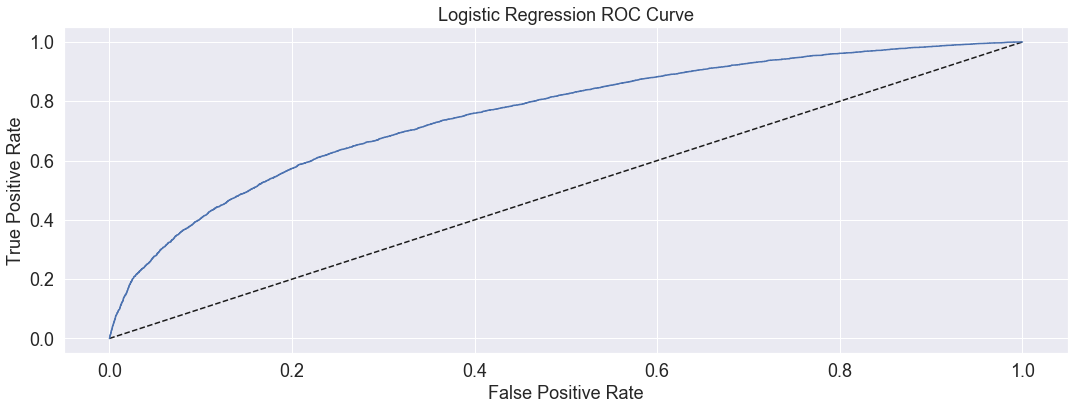

C:\Users\guzel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


It takes 70.623 seconds for K Nearest Neighbors fitting
Accuracy with K Nearest Neighborson the testing set is: 0.750
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7739      1620   9359
Retained              2125      3516   5641
Total                 9864      5136  15000
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      9359
           1       0.68      0.62      0.65      5641

    accuracy                           0.75     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.75      0.75      0.75     15000



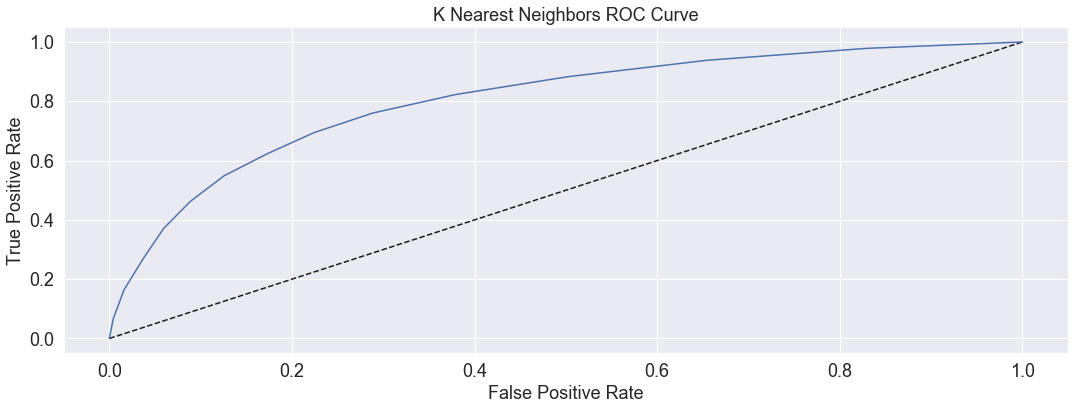

C:\Users\guzel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


It takes 3926.899 seconds for Support Vector Machine fitting
Accuracy with Support Vector Machineon the testing set is: 0.767
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          8178      1181   9359
Retained              2307      3334   5641
Total                10485      4515  15000
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      9359
           1       0.74      0.59      0.66      5641

    accuracy                           0.77     15000
   macro avg       0.76      0.73      0.74     15000
weighted avg       0.76      0.77      0.76     15000



C:\Users\guzel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


It takes 6.607 seconds for Decision Tree fitting
Accuracy with Decision Treeon the testing set is: 0.759
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7867      1492   9359
Retained              2117      3524   5641
Total                 9984      5016  15000
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      9359
           1       0.70      0.62      0.66      5641

    accuracy                           0.76     15000
   macro avg       0.75      0.73      0.74     15000
weighted avg       0.76      0.76      0.76     15000



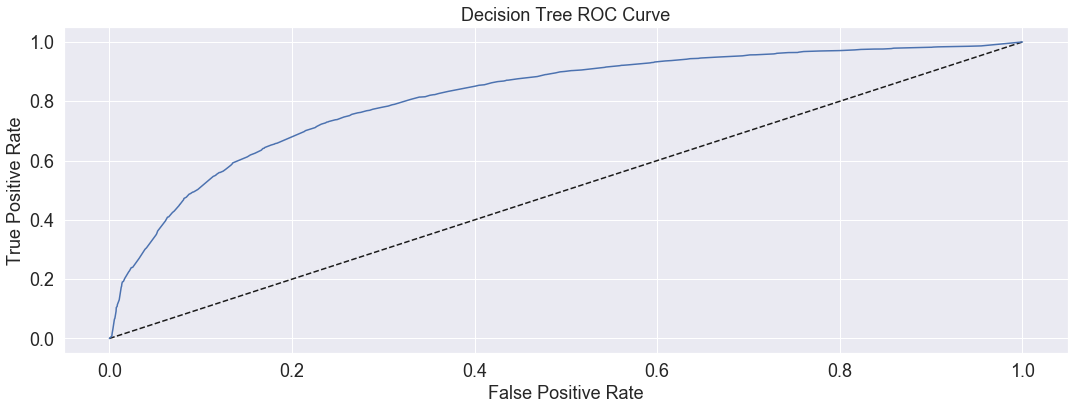

C:\Users\guzel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


It takes 73.261 seconds for Random Forest fitting
Accuracy with Random Foreston the testing set is: 0.778
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          8037      1322   9359
Retained              2002      3639   5641
Total                10039      4961  15000
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9359
           1       0.73      0.65      0.69      5641

    accuracy                           0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.78      0.78      0.78     15000



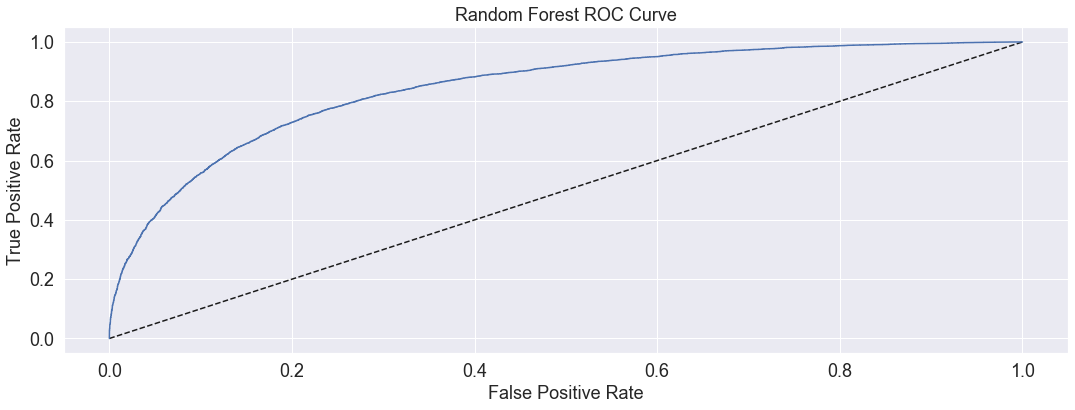

It takes 0.146 seconds for Naive Bayes fitting
Accuracy with Naive Bayeson the testing set is: 0.692
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          6419      2940   9359
Retained              1678      3963   5641
Total                 8097      6903  15000
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      9359
           1       0.57      0.70      0.63      5641

    accuracy                           0.69     15000
   macro avg       0.68      0.69      0.68     15000
weighted avg       0.71      0.69      0.70     15000



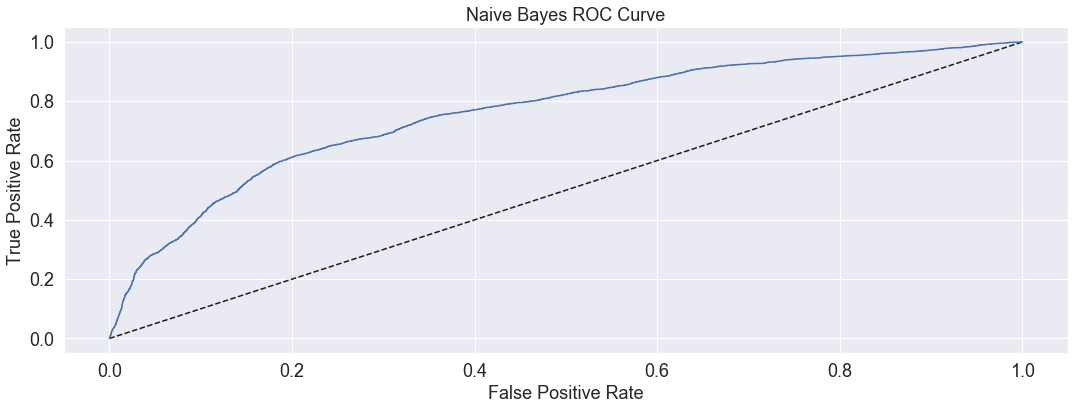

In [54]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                 ('classifier', classifier_dm)])
dm_cv = train_and_score_model('Dummy Model', pipeline, param_grid_dm)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_lr)])
lr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_knn)])
knn_cv = train_and_score_model('K Nearest Neighbors', pipeline, param_grid_knn)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_svm)])
svm_cv = train_and_score_model('Support Vector Machine', pipeline, param_grid_svm)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_dt)])
dt_cv = train_and_score_model('Decision Tree', pipeline, param_grid_dt)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_rf)])
rf_cv = train_and_score_model('Random Forest', pipeline, param_grid_rf)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_nb)])
nb_cv = train_and_score_model('Naive Bayes', pipeline, param_grid_nb)

In [55]:
from pandas.plotting import table
metrics.astype(float).round(3)
actual_metrics = metrics.astype(float).round(3).loc[['accuracy', 'precision', 'recall', 'AUC']]*100
actual_metrics

,Dummy Model,Logistic Regression,K Nearest Neighbors,Support Vector Machine,Decision Tree,Random Forest,Naive Bayes
accuracy,62.4,71.6,75.0,76.7,75.9,77.8,69.2
precision,0.0,66.8,68.5,73.8,70.3,73.4,57.4
recall,0.0,48.9,62.3,59.1,62.5,64.5,70.3
AUC,50.0,75.7,80.4,NaN,81.6,84.5,76.1


### Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

### Approach:

Ultimate's goal is to predict rider retention. Presumably this means they would like to predict users at risk for churn and target them for marketing campaigns, discounts, getting in touch, etc. that would retain these users.

As a result, our model emphasizes minimizing false positives (churned users misclassified as 'active' and thus missed by marketing campaigns, etc), while balancing a reasonable amount of false negatives ('active' users misclassified as churners who would then get spammed with these marketing campaigns).

### Predicting churned users

Random Forest algorithm produces the best model with accuracy of about 78%. In addition to having the highest accuracy of any model, we also see that it has the best AUC score of any model, or the best tradeoff between True positive rate and False positive rate. Besides that Random Forest model provides better interpretability than other models, especially in showing feature importance. For all those reasons with comparing other classification models, we chose a Random Forest model to be our model for prediction.

In terms of any concerns we have, the biggest concern would be that we might value false negative more highly than false positives or vice-versa. In that case, we would want to adjust the probability threshold for classification to reflect that.

In terms of model validity, our model is only as accurate as the input data. Also, our model is only as good as we the degree to which we know how to use it. That goes back to the point about precion-recall. First we have to know which we care about more before we can use our model optimally.

Finally, to reiterate the indicators of model performance, we achieved an accuracy of about 78%, and an AUC score of about 84.7%.

### Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [56]:
rf_model = rf_cv.best_estimator_

In [57]:
rf_model.named_steps['classifier'].feature_importances_

array([0.07287396, 0.0946823 , 0.05736528, 0.06949593, 0.08493398,
       0.04416002, 0.13768368, 0.1359289 , 0.12449299, 0.02722262,
       0.06768078, 0.01933287, 0.03240125, 0.00050753, 0.03123791])

- We have a problem, though, with getting the feature importances for our model, because scikit-learn does not allow us to extract the features from a pipeline object, so we need to fit our model again, using the optimal parameters that we have already found.

In [58]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
ultimate = pd.DataFrame(data)

ultimate['is_active'] = (ultimate['last_trip_date'] >= '2014-06-01')*1
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])
ultimate['signup_date'] = ultimate['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
ultimate['last_trip_date'] = (ultimate['last_trip_date'] - min(ultimate['last_trip_date'])).dt.days + 1 

ultimate.phone.fillna('Other', inplace=True)
ultimate['city'] = ultimate['city'].astype('category')
ultimate['phone'] = ultimate['phone'].astype('category')
ultimate = pd.get_dummies(ultimate)

In [59]:
# Imputation
ultimate['avg_rating_by_driver'].fillna(ultimate['avg_rating_by_driver'].mean(),inplace=True)
ultimate['avg_rating_of_driver'].fillna(ultimate['avg_rating_of_driver'].mean(),inplace=True)

In [60]:
# Split Data into Training and Test Sets
X = ultimate.drop(['is_active', 'last_trip_date'], axis=1)
y = ultimate['is_active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [61]:
# Instantiate the model/estimator
classifier_rf = RandomForestClassifier(random_state=0, criterion='gini', max_depth=20, 
                                       max_features=4, min_samples_leaf=7, min_samples_split=5, n_estimators=100)

In [62]:
# Fit on Training
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [63]:
# Feature importance as a table
pd.DataFrame(classifier_rf.feature_importances_, 
             index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
avg_rating_by_driver,0.151980
weekday_pct,0.130413
surge_pct,0.112422
city_King's Landing,0.098508
avg_dist,0.089670
avg_surge,0.083304
trips_in_first_30_days,0.062173
signup_date,0.059697
ultimate_black_user,0.052550
avg_rating_of_driver,0.041451


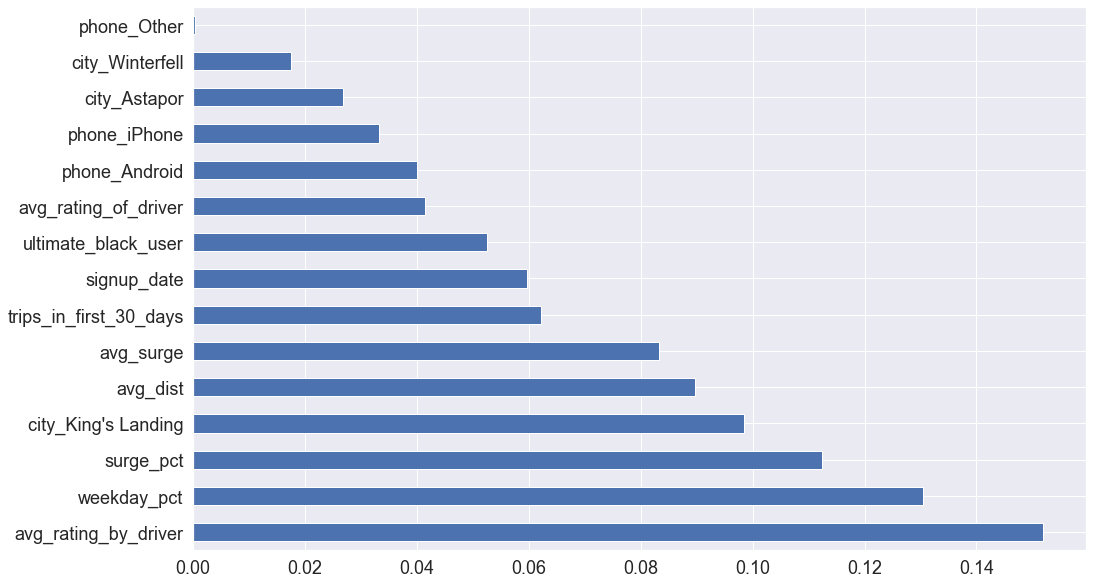

In [64]:
# Feature importance as a 
plt.figure(figsize=(16, 10))
feat_importances = pd.Series(classifier_rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [65]:
# Comparing important features' correlation with the target variable
display(ultimate['avg_rating_by_driver'].corr(ultimate['is_active']))
display(ultimate['surge_pct'].corr(ultimate['is_active']))
display(ultimate['weekday_pct'].corr(ultimate['is_active']))
display(ultimate["city_King's Landing"].corr(ultimate['is_active']))

-0.02674804280606973

0.011796748066780126

0.009692972843291875

0.2622835570326674

The features that were most predictive of 'active'/'inactive' are shown above. As a result, our further recommendations to Ultimate are:

#### Promote positive driver-rider interaction.
It seems lower average rating by driver --> more risk for rider churning. Riders probably had dissatisfactory experiences. Encourage drivers to offer amenities that don't cost them much, such as water, candy, etc. Encourage them to ask a basic set of questions to improve rider mood/reduce likelihood of bad driver interaction, such as offering to roll down window, asking about AC, music, etc. Thus, average rating by driver may improve, resulting in less churning.

#### More research on surge:
The second most important feature was the percent of trips taken with surge multiplier > 1. We know that this is very slightly positively correlated with retention.ince there is no clear connection here, the best we can say is that Ultimate should do more research into the effects of surges on user retention. Perhaps it is charging surge prices too much and that is scaring users away.

#### Target churners with weekday discounts.
From our analysis, percent of user's trips during weekday is important predictor of churning. Increasing churners' weekday trips may therefore improve likelihood of them remaining customers. This could be accomplished by offering them weekday discounts for their Ultimate trips, making Ultimate more of a weekday routine for them and therefore increasing the likelihood they will remain active users.

#### Research on King's Landing:
King's Landingseems to be especially successful in retaining users whereas Astapor is the least successful. Ultimate has to see what is unique about King's Landing drivers and passengers and check if it can be implemented in the other cities, especially Astapor.